# DM-31053: Processing tract 8913 of COSMOS through the AP Pipeline using synthetic source injection ("fakes")

* Used w_2021_30
* Pipeline is in `/project/mrawls/repo-main-logs/ApPipe_DM31053.yaml`
* BPS configuration file is in `/project/mrawls/repo-main-logs/ApPipe_DM31053_bps.yaml`
* Logs are in `/project/mrawls/repo-main-logs/bps/u/mrawls/DM-31053-HSC-fakes/20210726T165409Z`
* Repository is `/repo/main` and collection is `u/mrawls/DM-31053-HSC-fakes`
* APDB is in Postgres at `lsstdevapdb1` in schema `mrawls_DM31053`.

In [1]:
%matplotlib notebook

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import importlib
import pandas as pd

from astropy.coordinates import SkyCoord
import astropy.units as u

import lsst.geom
import lsst.daf.butler as dafButler
from lsst.ap.association import UnpackApdbFlags, TransformDiaSourceCatalogConfig

sys.path.append('/project/mrawls/ap_pipe-notebooks/')
import diaObjectAnalysis as doa
import apdbPlots as pla
import plotLightcurve as plc
import coaddAnalysis as coa

In [ ]:
# Only if you change anything in the code imported above
importlib.reload(doa)
importlib.reload(pla)
importlib.reload(plc)
importlib.reload(coa)

In [2]:
repo = '/repo/main'
butler = dafButler.Butler(repo)

In [3]:
collection = 'u/mrawls/DM-31053-HSC-fakes'
dbSchema = 'mrawls_DM31053'
instrument = 'HSC'

In [4]:
badFlagList = ['base_PixelFlags_flag_bad',
               'base_PixelFlags_flag_suspect',
               'base_PixelFlags_flag_saturatedCenter',
               'base_PixelFlags_flag_interpolated',
               'base_PixelFlags_flag_interpolatedCenter',
               'base_PixelFlags_flag_edge',
              ]

In [5]:
objTable, srcTable, goodObj, goodSrc = pla.loadTables(repo,
                                                      dbType='postgres',
                                                      dbName='lsstdevapdb1',
                                                      schema=dbSchema,
                                                      gen='gen3',
                                                      instrument=instrument,
                                                      badFlagList=badFlagList)

In [6]:
srcTable = pla.addVisitCcdToSrcTable(srcTable, instrument=instrument, gen='gen3', butler=butler)
flagTable, srcTableFlags, flagFilter, goodSrc, goodObj = pla.makeSrcTableFlags(srcTable, objTable,
                                                                               badFlagList=badFlagList,
                                                                               gen='gen3', instrument=instrument,
                                                                               repo=repo)

<IPython.core.display.Javascript object>


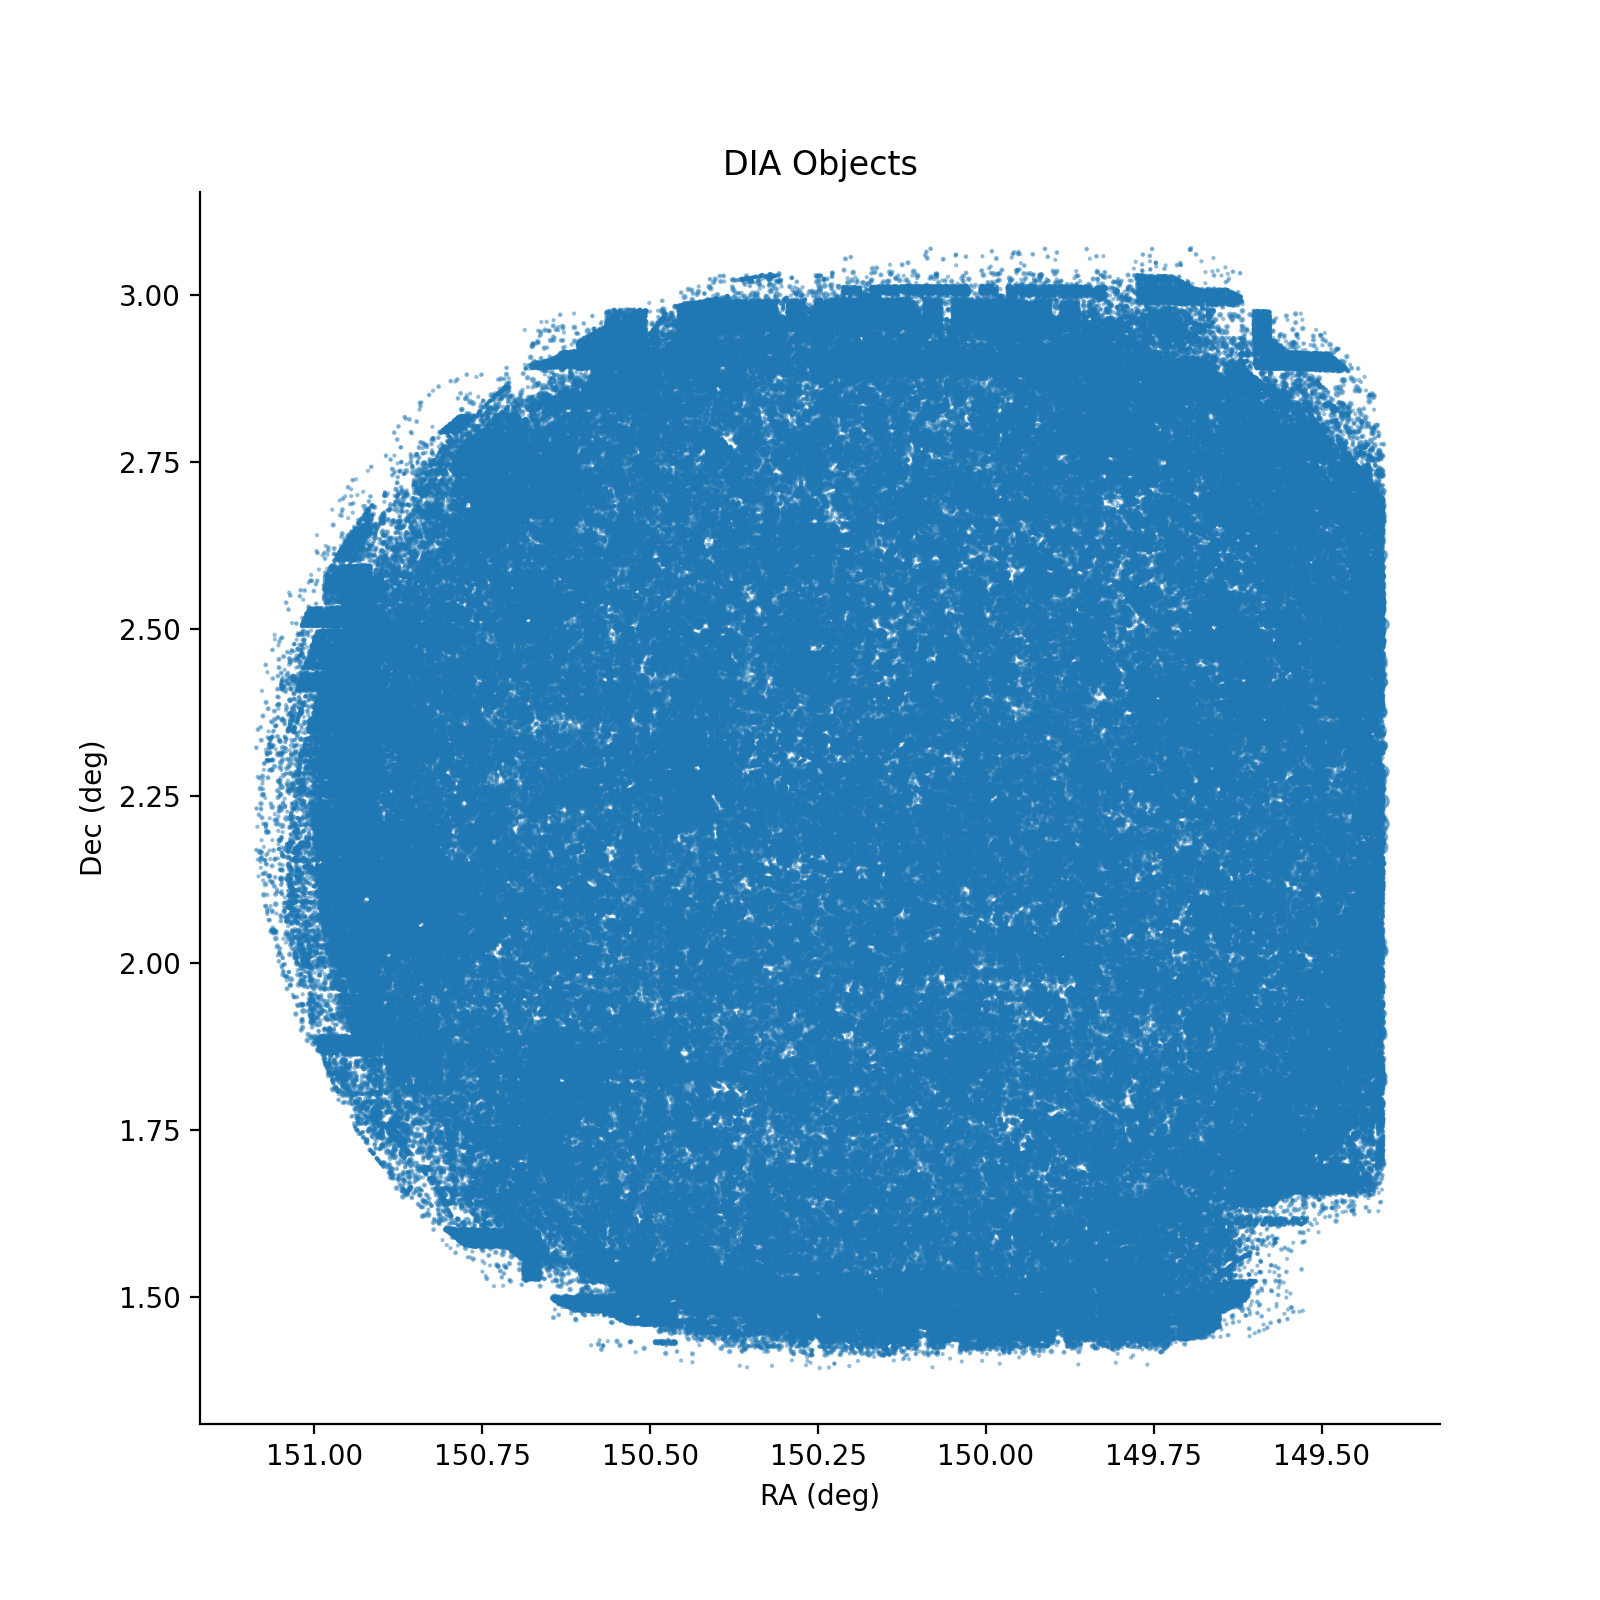

In [7]:
fig = plt.figure(figsize=(8,8))

cutoff = 0  # only plot DIA Objects composed more than cutoff DIA Sources

ax = fig.add_subplot(111)
#plt.setp(ax, xlim=xlim, ylim=ylim)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.scatter(goodObj.loc[goodObj['nDiaSources'] > cutoff, 'ra'], goodObj.loc[goodObj['nDiaSources'] > cutoff, 'decl'], 
           c='C0', s=goodObj.loc[goodObj['nDiaSources'] > cutoff, 'nDiaSources'], marker='.', alpha=0.5)
ax.set_xlabel('RA (deg)')
ax.set_ylabel('Dec (deg)')
ax.set_title(f'DIA Objects')
ax.invert_xaxis()

## Access synthetic source information

There is probably a better Butler way to do this, but poking around in the filepath reveals that there is a parquet file in the `fakes_fakeSourceCat` subdirectory which has the coordinates and magnitudes of all the synthetic sources.

In [9]:
fakes_path = '20210726T165409Z/fakes_fakeSourceCat/9813/fakes_fakeSourceCat_9813_hsc_rings_v1_u_mrawls_DM-31053-HSC-fakes_20210726T165409Z.parq'
insertedFakes = pd.read_parquet(os.path.join(repo, collection, fakes_path))

In [10]:
insertedFakes

,fakeId,decJ2000,raJ2000,isVisitSource,isTemplateSource,umagVar,gmagVar,rmagVar,imagVar,zmagVar,...,BulgeHalfLightRadius,disk_n,bulge_n,a_d,a_b,b_d,b_b,pa_disk,pa_bulge,sourceType
0,13761891381329697611,0.042086,2.621927,True,False,21.922979,21.922979,21.922979,21.922979,21.922979,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,star
1,12142683971509363194,0.054474,2.617293,True,False,24.851600,24.851600,24.851600,24.851600,24.851600,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,star
2,10596765969385587114,0.044058,2.624939,True,False,20.562586,20.562586,20.562586,20.562586,20.562586,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,star
3,12323145283509846526,0.049406,2.636752,True,False,20.784443,20.784443,20.784443,20.784443,20.784443,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,star
4,10035903681115321549,0.024249,2.613563,True,False,24.036132,24.036132,24.036132,24.036132,24.036132,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,star
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8858,11801718036666786693,0.047203,2.605755,False,True,21.863603,21.863603,21.863603,21.863603,21.863603,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,star
8859,10848229391910931576,0.039926,2.628002,False,True,25.882399,25.882399,25.882399,25.882399,25.882399,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,star
8860,12063873166280880700,0.034792,2.615861,False,True,24.457112,24.457112,24.457112,24.457112,24.457112,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,star
8861,12311760249105304995,0.027856,2.615822,False,True,25.393506,25.393506,25.393506,25.393506,25.393506,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,star


In [11]:
assert(len(insertedFakes) == len(insertedFakes.drop_duplicates()))

In [15]:
insertedFakes.loc[:,'ra'] = np.degrees(insertedFakes['raJ2000'])
insertedFakes.loc[:,'decl'] = np.degrees(insertedFakes['decJ2000'])
skycoordFakes = SkyCoord(insertedFakes.ra, insertedFakes.decl, unit=u.degree)

In [16]:
skycoordObjects = SkyCoord(goodObj.ra, goodObj.decl, unit=u.degree)

<IPython.core.display.Javascript object>


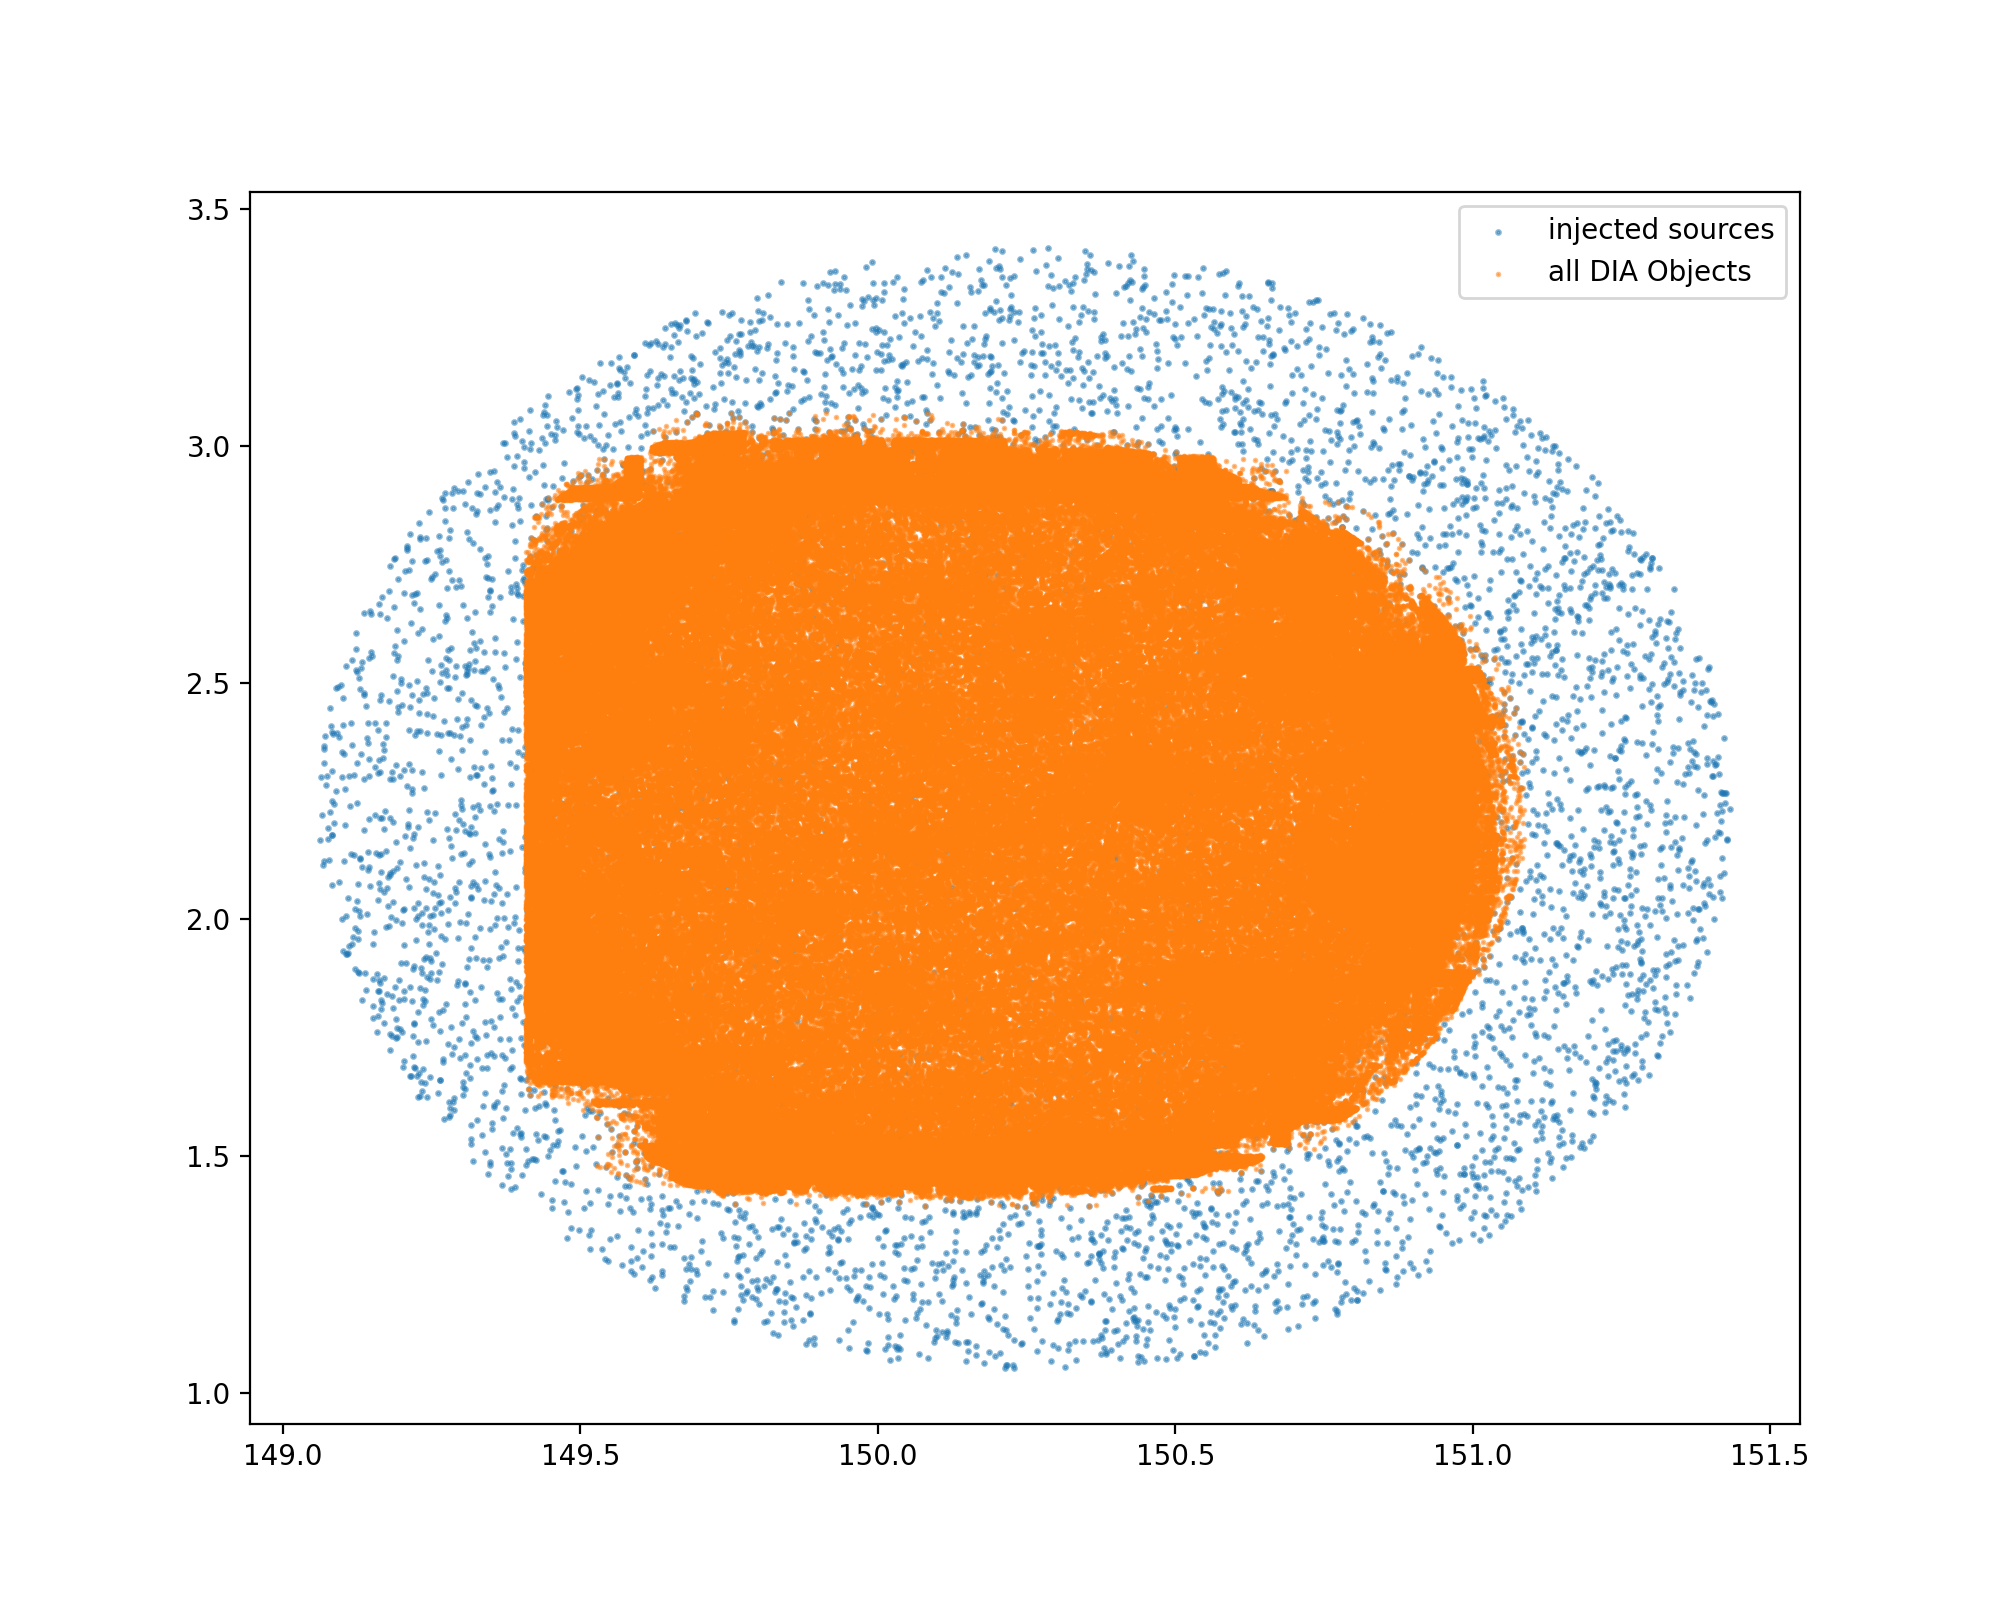

In [26]:
figure = plt.figure(figsize=(10,8))
plt.scatter(skycoordFakes.ra, skycoordFakes.dec, label='injected sources', s=2, alpha=0.5)
plt.scatter(skycoordObjects.ra, skycoordObjects.dec, label='all DIA Objects', s=1, alpha=0.5)
plt.legend()

In [27]:
idx, d2d, d3d = skycoordFakes.match_to_catalog_sky(skycoordObjects)

In [38]:
whereMatches = d2d < 1*u.arcsec

In [39]:
fakesWithDiaObjects = insertedFakes.iloc[np.nonzero(whereMatches)[0]]
fakesWithoutDiaObjects = insertedFakes.iloc[np.nonzero(~whereMatches)[0]]
fakeMatchedDiaObjects = goodObj.iloc[idx[whereMatches]]

In [40]:
assert(len(fakesWithDiaObjects) + len(fakesWithoutDiaObjects) == len(insertedFakes))

In [41]:
fakesWithDiaObjects

,fakeId,decJ2000,raJ2000,isVisitSource,isTemplateSource,umagVar,gmagVar,rmagVar,imagVar,zmagVar,...,bulge_n,a_d,a_b,b_d,b_b,pa_disk,pa_bulge,sourceType,ra,decl
0,13761891381329697611,0.042086,2.621927,True,False,21.922979,21.922979,21.922979,21.922979,21.922979,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,star,150.225376,2.411328
2,10596765969385587114,0.044058,2.624939,True,False,20.562586,20.562586,20.562586,20.562586,20.562586,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,star,150.397951,2.524357
8,10163342486736267105,0.040876,2.625746,True,False,23.585313,23.585313,23.585313,23.585313,23.585313,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,star,150.444147,2.342006
10,9433904397441864433,0.030001,2.609656,True,False,20.479537,20.479537,20.479537,20.479537,20.479537,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,star,149.522252,1.718923
11,10675096313772189930,0.051063,2.617753,True,False,21.878463,21.878463,21.878463,21.878463,21.878463,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,star,149.986221,2.925718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8856,12720020450037996210,0.038840,2.625920,False,True,20.320703,20.320703,20.320703,20.320703,20.320703,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,star,150.454141,2.225388
8857,10147916298857893195,0.045865,2.612899,False,True,23.064940,23.064940,23.064940,23.064940,23.064940,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,star,149.708085,2.627855
8859,10848229391910931576,0.039926,2.628002,False,True,25.882399,25.882399,25.882399,25.882399,25.882399,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,star,150.573419,2.287578
8860,12063873166280880700,0.034792,2.615861,False,True,24.457112,24.457112,24.457112,24.457112,24.457112,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,star,149.877815,1.993438


In [42]:
len(fakesWithDiaObjects)

4691

In [43]:
len(insertedFakes)

8863

In [44]:
goodObj.columns

Index(['diaObjectId', 'ra', 'decl', 'nDiaSources', 'gPSFluxMean',
       'rPSFluxMean', 'iPSFluxMean', 'zPSFluxMean', 'yPSFluxMean',
       'validityEnd', 'flags'],
      dtype='object')

In [45]:
fakesWithDiaObjects.columns

Index(['fakeId', 'decJ2000', 'raJ2000', 'isVisitSource', 'isTemplateSource',
       'umagVar', 'gmagVar', 'rmagVar', 'imagVar', 'zmagVar', 'ymagVar',
       'DiskHalfLightRadius', 'BulgeHalfLightRadius', 'disk_n', 'bulge_n',
       'a_d', 'a_b', 'b_d', 'b_b', 'pa_disk', 'pa_bulge', 'sourceType', 'ra',
       'decl'],
      dtype='object')

In [46]:
wCalexpMatchedFakes = fakesWithDiaObjects['isVisitSource']
wCalexpUnmatchedFakes = fakesWithoutDiaObjects['isVisitSource']

In [51]:
bins = np.linspace(19, 26, 50)
n_matched, edges = np.histogram(fakesWithDiaObjects.loc[wCalexpMatchedFakes,'gmagVar'], bins=bins)
nmatched_err = np.sqrt(n_matched)
n_unmatched, edges = np.histogram(fakesWithoutDiaObjects.loc[wCalexpUnmatchedFakes,'gmagVar'], bins=bins)
ntot = n_matched + n_unmatched
ntot_err = np.sqrt(ntot) # compute on total to keep Poisson errors in gaussian regime
completeness = n_matched/ntot
completeness_err = completeness * np.sqrt((nmatched_err/n_matched)**2. + (ntot_err/ntot)**2.)

<ipython-input-51-4a98a49d0886>:7: RuntimeWarning: invalid value encountered in true_divide
  completeness = n_matched/ntot
<ipython-input-51-4a98a49d0886>:8: RuntimeWarning: invalid value encountered in true_divide
  completeness_err = completeness * np.sqrt((nmatched_err/n_matched)**2. + (ntot_err/ntot)**2.)


<IPython.core.display.Javascript object>


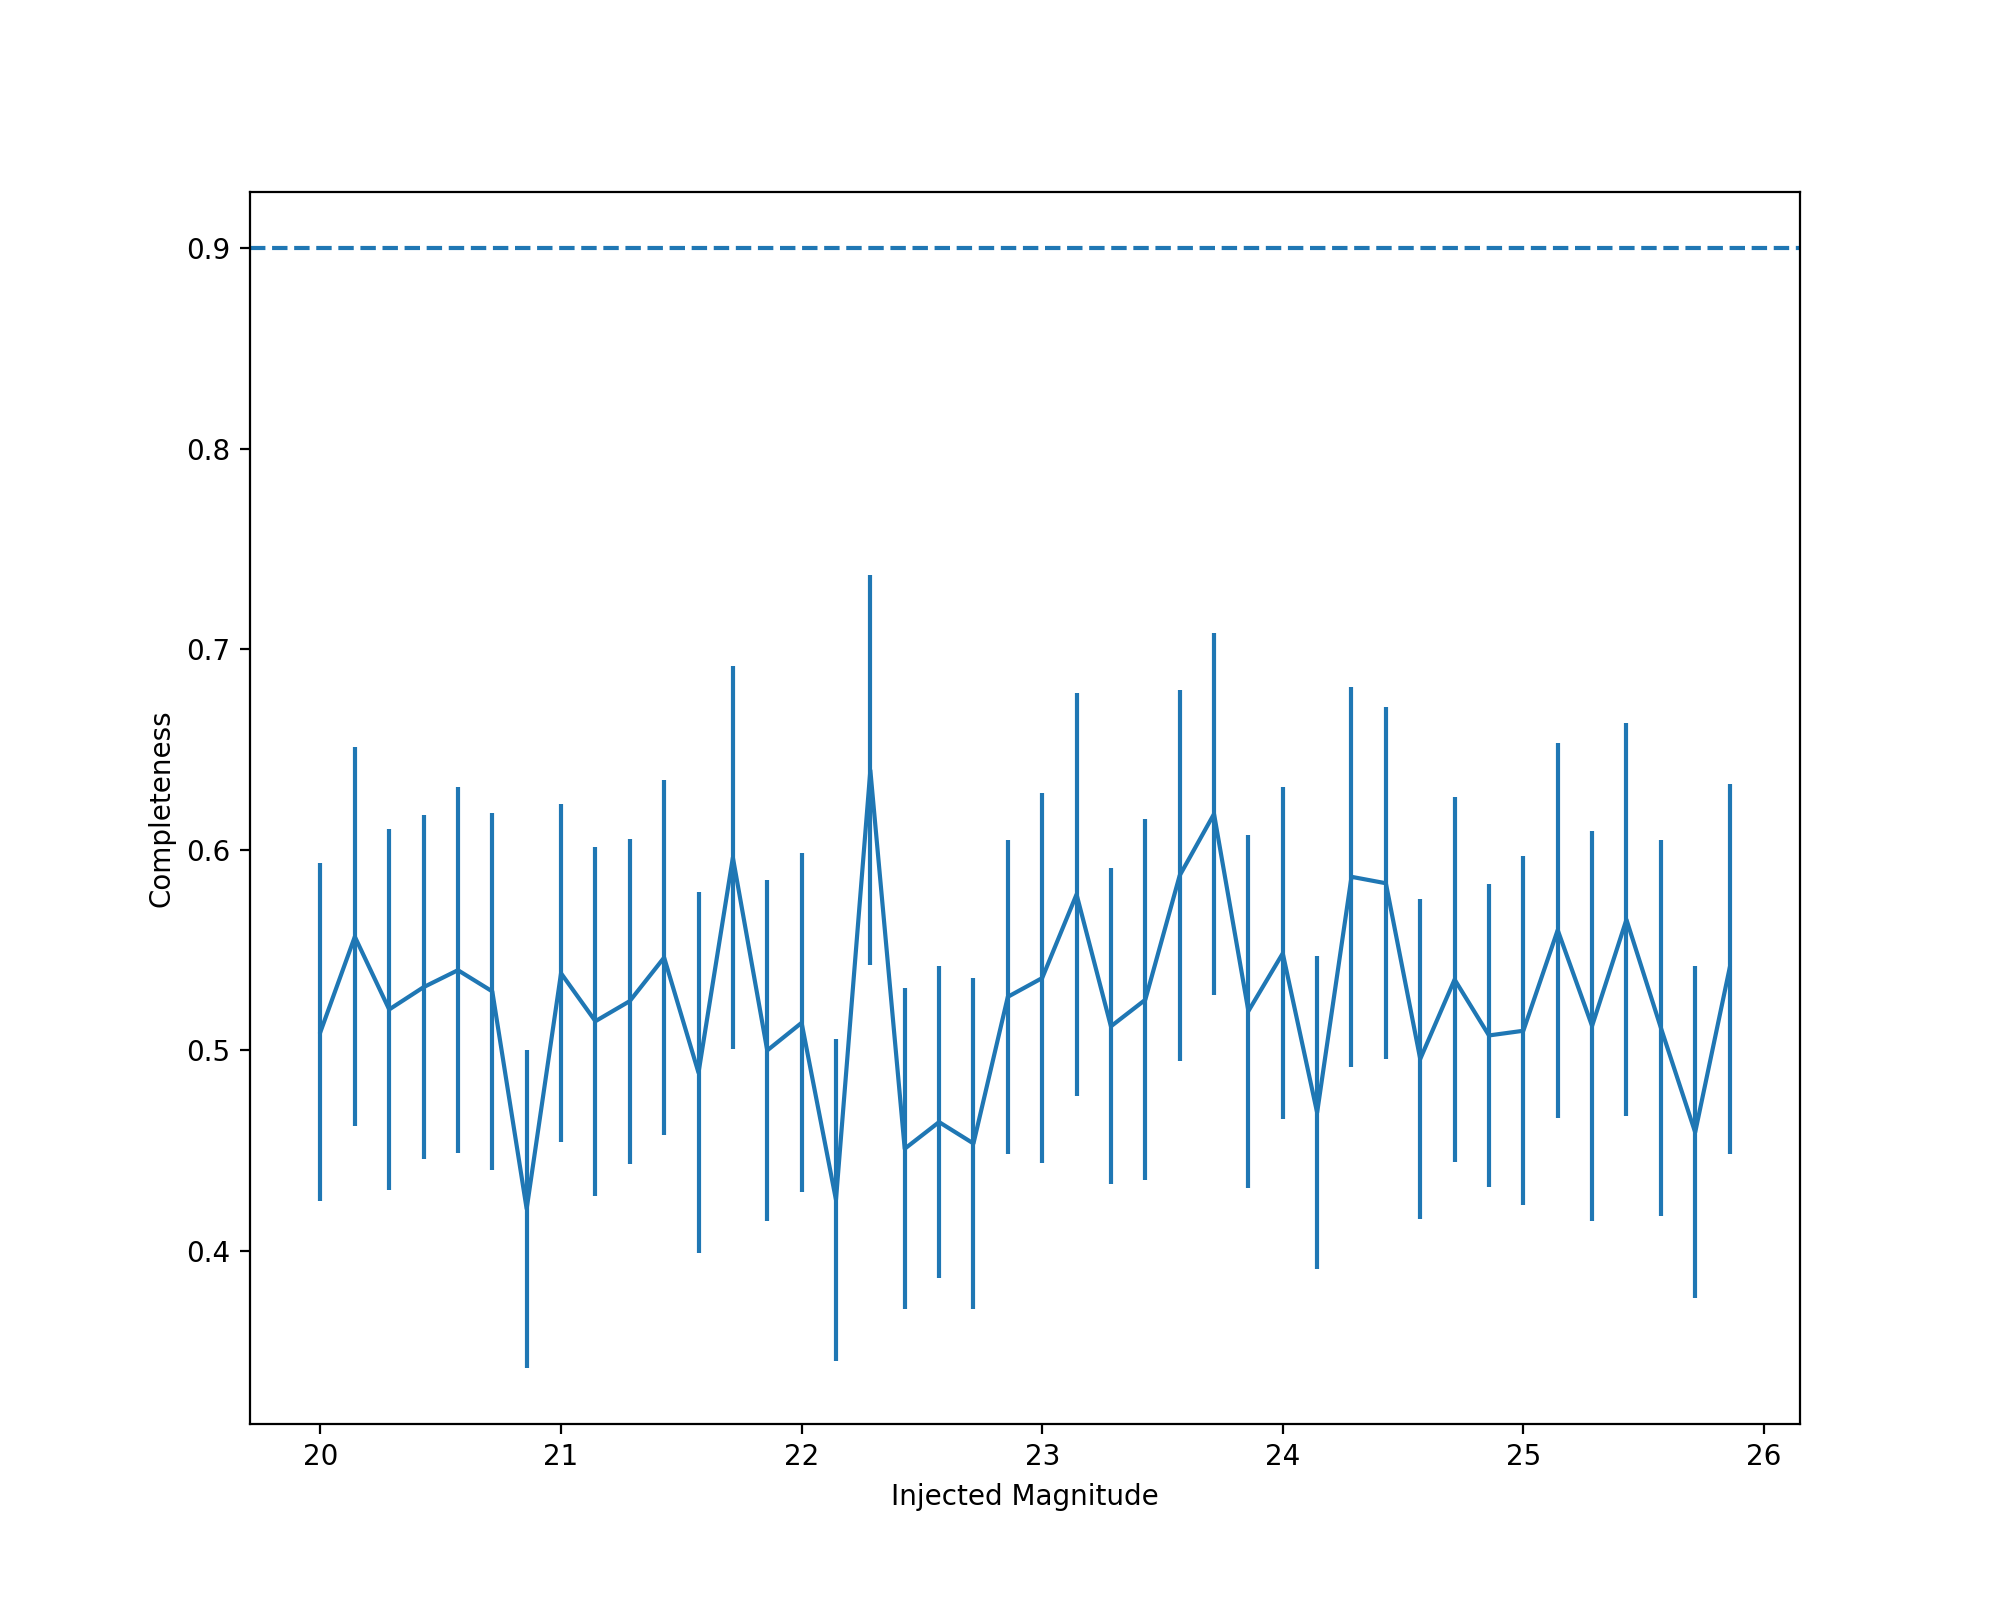

Text(0, 0.5, 'Completeness')

In [52]:
figure = plt.figure(figsize=(10,8))
plt.errorbar(bins[0:-1],completeness, completeness_err)

plt.axhline(.9,ls='--')
plt.xlabel('Injected Magnitude')
plt.ylabel('Completeness')
#plt.ylim(0.75,1.)